In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import os
import pandas as pd
!pip install tabulate
from tabulate import tabulate
import matplotlib.pyplot as plt
import torchvision
from torchvision.models import resnet50
from torchvision.models import resnet50


### Model size Pruning

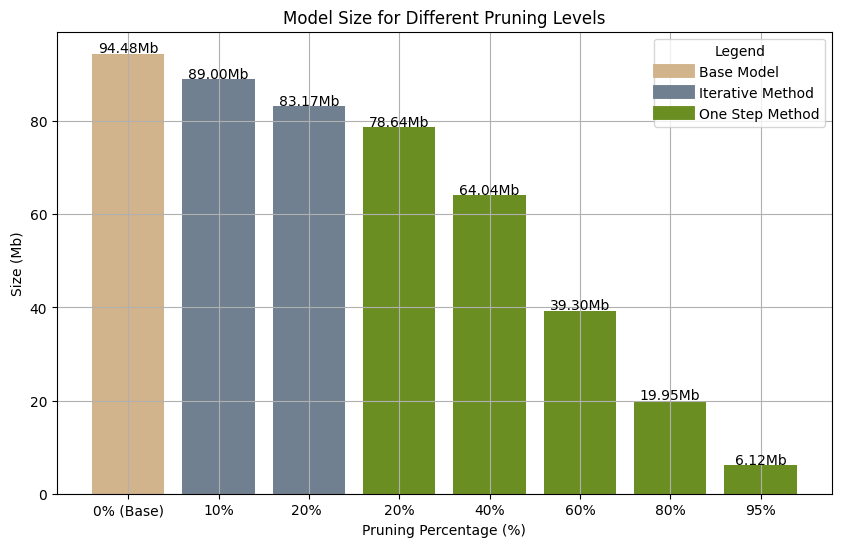

In [6]:
original_model_size = os.path.getsize('pruning/models/teacher.pth') / 1024/1000
it01_model_size = os.path.getsize('pruning/models/cg_pruned_it01_sparse_2.pth') / 1024/1000
it02_model_size = os.path.getsize('pruning/models/cg_pruned_it02_sparse_2.pth') / 1024/1000
os02_model_size = os.path.getsize('pruning/models/cg_pruned_os02_mask.pth') / 1024/1000
os04_model_size = os.path.getsize('pruning/models/cg_pruned_os04_mask.pth') / 1024/1000
os06_model_size = os.path.getsize('pruning/models/cg_pruned_os06_mask.pth') / 1024/1000
os08_model_size = os.path.getsize('pruning/models/cg_pruned_os08_mask.pth') / 1024/1000
os095_model_size = os.path.getsize('pruning/models/cg_pruned_os095_mask.pth') / 1024/1000

# Etiquetas para cada modelo
labels = ['0% (Base)', '10%', '20% ', '20%', '40%','60%','80%','95%']

# Valores de tamaño
sizes = [original_model_size, it01_model_size, it02_model_size, os02_model_size, os04_model_size, os06_model_size, os08_model_size, os095_model_size,]

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
plt.bar(labels, sizes, color=['tan','slategrey','slategrey','olivedrab','olivedrab','olivedrab', 'olivedrab', 'olivedrab'])

# Agregar títulos y etiquetas
plt.title('Model Size for Different Pruning Levels')
plt.xlabel('Pruning Percentage (%)')
plt.ylabel('Size (Mb)')

# Mostrar valores exactos encima de cada barra
for i, v in enumerate(sizes):
    plt.text(i, v + 0.2, f'{v:.2f}Mb', ha='center', fontsize=10)
legend_handles = [
    plt.Line2D([0], [0], color='tan', lw=10, label='Base Model'),
    plt.Line2D([0], [0], color='slategrey', lw=10, label='Iterative Method'),
    plt.Line2D([0], [0], color='olivedrab', lw=10, label='One Step Method'),
]
plt.legend(handles=legend_handles, title='Legend', loc='upper right')
# Mostrar la gráfica
#plt.ylim([min(accuracies) - 5, 100])  # Ajustar el eje y para mejor visualización
plt.grid(True)
plt.savefig('size_pruning_levels.png', dpi=300, bbox_inches='tight')  # Ajustar DPI y bordes para calidad óptima
plt.show()

### Accuracy Pruning Models

In [4]:
# Transformaciones para el dataset CIFAR-10
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Cambiamos el tamaño de las imágenes para que se ajusten a ResNet-50
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizamos las imágenes
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)
def test(path, device, test_loader):
    model=base_model()
    model.load_state_dict(torch.load(path))
    model.to(device)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    acc = 100. * correct / len(test_loader.dataset)
    return acc

# Definir la arquitectura del modelo como antes
def base_model():
    # Cargar el modelo base ResNet-50
    model = resnet50(weights=True)

    # Congelar todas las capas menos la fc
    for param in model.parameters():
        param.requires_grad = False

    # Modificar la capa totalmente conectada (fc)
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 256),  # Nueva capa oculta
        nn.ReLU(),                             # Activación
        nn.Dropout(0.5),                       # Dropout
        nn.Linear(256,256),                    # Nueva capa oculta
        nn.Linear(256, 10) 
    )

    return model

Files already downloaded and verified


In [5]:
acc_original=82.20
acc_it01=test('pruning/models/cg_pruned_it01_mask_2.pth', 'cuda', testloader)
acc_it02=test('pruning/models/cg_pruned_oit02_mask_2.pth', 'cuda', testloader)
acc_os02=test('pruning/models/cg_pruned_os02_sparse.pth', 'cuda', testloader)
acc_os04=test('pruning/models/cg_pruned_os04_sparse.pth', 'cuda', testloader)
acc_os06=test('pruning/models/cg_pruned_os06_sparse.pth', 'cuda', testloader)
acc_os08=test('pruning/models/cg_pruned_os08_sparse.pth', 'cuda', testloader)
acc_os095=test('pruning/models/cg_pruned_os095_sparse.pth', 'cuda', testloader)



/root/miniconda3/envs/dl/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_120/3377028831.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to 

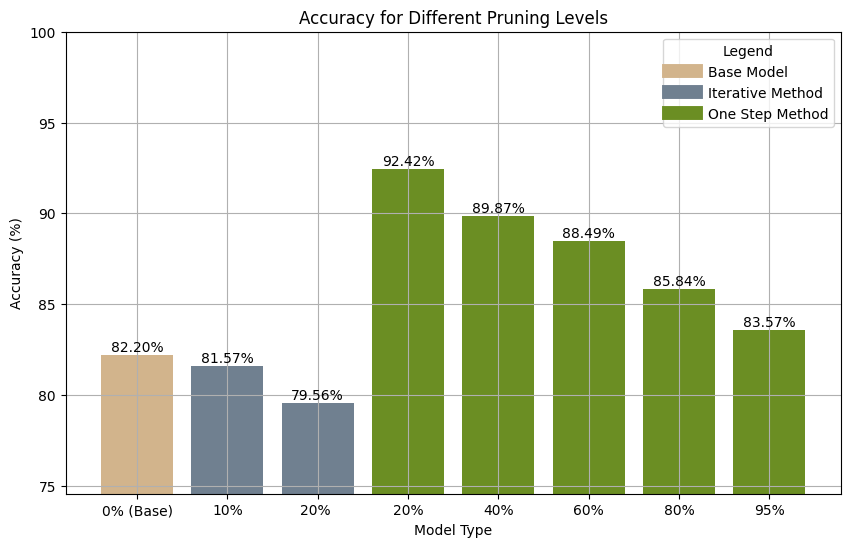

In [5]:
# Etiquetas para cada modelo
labels = ['0% (Base)', '10%', '20% ', '20%', '40%','60%','80%','95%']

# Valores de precisión
accuracies = [acc_original, acc_it01, acc_it02, acc_os02, acc_os04, acc_os06, acc_os08, acc_os095]

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
plt.bar(labels, accuracies, color=['tan','slategrey','slategrey','olivedrab','olivedrab','olivedrab', 'olivedrab', 'olivedrab'])

# Agregar títulos y etiquetas
plt.title('Accuracy for Different Pruning Levels')
plt.xlabel('Pruning Percentage (%)')
plt.ylabel('Accuracy (%)')

# Mostrar valores exactos encima de cada barra
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.2, f'{v:.2f}%', ha='center', fontsize=10)

# Mostrar la gráfica
plt.ylim([min(accuracies) - 5, 100])  #Vitis-AI/vitis_repo/models/modelo_completo_resnet50_cifar10.pth Ajustar el eje y para mejor visualización
plt.grid(True)
legend_handles = [
    plt.Line2D([0], [0], color='tan', lw=10, label='Base Model'),
    plt.Line2D([0], [0], color='slategrey', lw=10, label='Iterative Method'),
    plt.Line2D([0], [0], color='olivedrab', lw=10, label='One Step Method'),
]
plt.legend(handles=legend_handles, title='Legend', loc='upper right')
plt.savefig('accuracy_pruning_levels.png', dpi=300, bbox_inches='tight')  # Ajustar DPI y bordes para calidad óptima
plt.show()


## Quantization

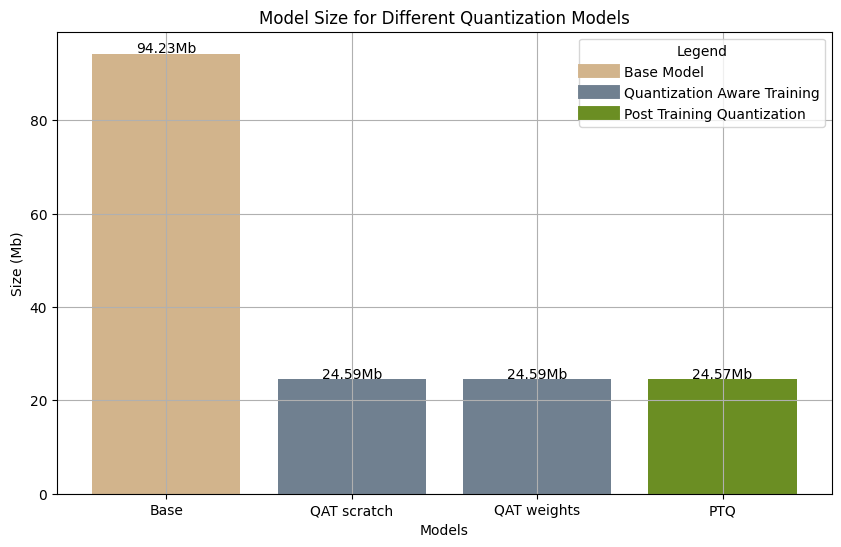

In [6]:
original_model_size = os.path.getsize('models/modelo_completo_resnet50_cifar10.pth') / 1024/1000
qat_noweights = os.path.getsize('qat_results/compiled_model/ResNet_zcu104.xmodel') / 1024/1000
qat_withweights = os.path.getsize('qat_results_with_weights/compiled_model/ResNet_zcu104.xmodel') / 1024/1000
ptq = os.path.getsize('quantization_output/compiled_model/ResNet_zcu104.xmodel') / 1024/1000

# Etiquetas para cada modelo
labels = ['Base', 'QAT scratch', 'QAT weights', 'PTQ']

# Valores de tamaño
sizes = [original_model_size, qat_noweights, qat_withweights, ptq]

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
plt.bar(labels, sizes, color=['tan','slategrey','slategrey','olivedrab'])

# Agregar títulos y etiquetas
plt.title('Model Size for Different Quantization Models')
plt.xlabel('Models')
plt.ylabel('Size (Mb)')

# Mostrar valores exactos encima de cada barra
for i, v in enumerate(sizes):
    plt.text(i, v + 0.2, f'{v:.2f}Mb', ha='center', fontsize=10)
legend_handles = [
    plt.Line2D([0], [0], color='tan', lw=10, label='Base Model'),
    plt.Line2D([0], [0], color='slategrey', lw=10, label='Quantization Aware Training'),
    plt.Line2D([0], [0], color='olivedrab', lw=10, label='Post Training Quantization'),
]
plt.legend(handles=legend_handles, title='Legend', loc='upper right')
# Mostrar la gráfica
#plt.ylim([min(accuracies) - 5, 100])  # Ajustar el eje y para mejor visualización
plt.grid(True)
plt.savefig('size_quantization_vitis.png', dpi=300, bbox_inches='tight')  # Ajustar DPI y bordes para calidad óptima
plt.show()

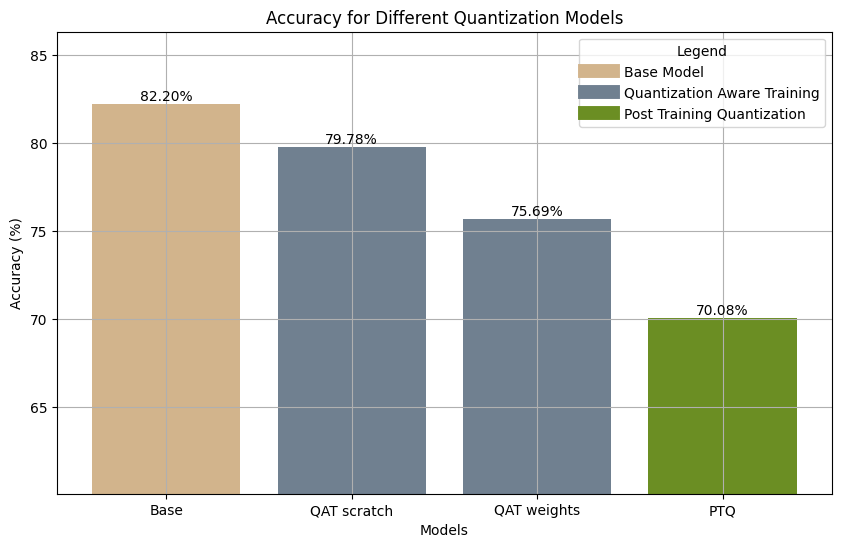

In [7]:
# Etiquetas para cada modelo
labels = ['Base', 'QAT scratch', 'QAT weights', 'PTQ']

# Valores de tamaño
accuracies = [82.2, 79.78, 75.69, 70.08]

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
plt.bar(labels, accuracies, color=['tan','slategrey','slategrey','olivedrab'])

# Agregar títulos y etiquetas
plt.title('Accuracy for Different Quantization Models')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')

# Mostrar valores exactos encima de cada barra
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.2, f'{v:.2f}%', ha='center', fontsize=10)
legend_handles = [
    plt.Line2D([0], [0], color='tan', lw=10, label='Base Model'),
    plt.Line2D([0], [0], color='slategrey', lw=10, label='Quantization Aware Training'),
    plt.Line2D([0], [0], color='olivedrab', lw=10, label='Post Training Quantization'),
]
plt.legend(handles=legend_handles, title='Legend', loc='upper right')
# Mostrar la gráfica
#plt.ylim([min(accuracies) - 5, 100])  # Ajustar el eje y para mejor visualización
plt.ylim(60.100)
plt.grid(True)
plt.savefig('acc_quantization_vitis.png', dpi=300, bbox_inches='tight')  # Ajustar DPI y bordes para calidad óptima
plt.show()